In [1]:
#import packages and wrangle data
%%capture
import sys

filepath = 'Boxing Champions Final.csv'

!pip install pandas-profiling==2.*


def wrangle(filepath):
    df = pd.read_csv(filepath,parse_dates=['Date'])
    return df

In [2]:
#examine data to examine df for NaNs, null values and missing values
import pandas as pd
df = wrangle (filepath)

df.head()

,Belt,Division,Division Group,No.,Name,Country,Date,Location,Defenses,Days,Ended,Notes,Next Champ Date,Day until Next Champ,Region,Continent,Title Type
0,WBA,Heavyweight,Heavyweight,1,Floyd Patterson,US,1962-08-23,NaN,0,34,NaN,Patterson won the NBA title from Ingemar Johan...,9/25/1962,33.0,North America,North America,NaN
1,WBA,Heavyweight,Heavyweight,2,Sonny Liston,US,1962-09-25,NaN,1,519,NaN,NaN,2/25/1964,518.0,North America,North America,NaN
2,WBA,Heavyweight,Heavyweight,3,Muhammad Ali,US,1964-02-25,NaN,0,?,NaN,Ali was stripped for facing Liston in a rematc...,3/5/1965,374.0,North America,North America,NaN
3,WBA,Heavyweight,Heavyweight,4,Ernie Terrell (v. Eddie Machen),US,1965-03-05,NaN,2,703,NaN,NaN,2/6/1967,703.0,North America,North America,NaN
4,WBA,Heavyweight,Heavyweight,5,Muhammad Ali (2),US,1967-02-06,NaN,1,446,NaN,Ali was stripped due to his refusal to be draf...,4/27/1968,446.0,North America,North America,NaN


In [3]:
#summary of NA values in dataset
df.isna().sum()

Belt                       0
Division                   0
Division Group             0
No.                        0
Name                       0
Country                    0
Date                       0
Location                1062
Defenses                   0
Days                     627
Ended                   1285
Notes                   1228
Next Champ Date           68
Day until Next Champ      68
Region                     0
Continent                  0
Title Type              1907
dtype: int64

In [4]:
#drop NAs to make it easier to work with data
df.dropna(subset=['Day until Next Champ'],inplace=True)

In [6]:
#pandas profiling to check for missing values, high cardinality, categorical variables, etc
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True).to_notebook_iframe()

profile

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

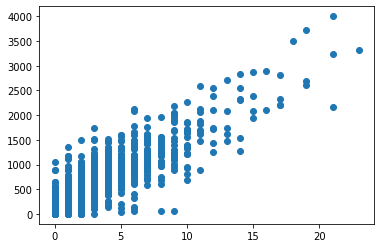

In [7]:
#domain specific knowledge to gut check hypothesis that more title defenses
#means longer time as boxing division champion
#Visualization 1
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(x=df['Defenses'], y=df['Day until Next Champ'])
x_space = np.linspace(500, 3000, 1000)

In [8]:
#feature engineering to see how many fights from dataset
#fall into each era 
df.loc[df['Date']>'01-01-1970', 'Era' ] ='1970s'
df.loc[df['Date']<'01-01-1970', 'Era' ] ='1960s'
df.loc[df['Date']>'01-01-1980', 'Era' ] ='1980s'
df.loc[df['Date']>'01-01-1990', 'Era' ] ='1990s'
df.loc[df['Date']>'01-01-2000', 'Era' ] ='2000s'

df['Era']

0       1960s
1       1960s
2       1960s
3       1960s
4       1960s
        ...  
2085    2000s
2086    2000s
2087    2000s
2088    2000s
2089    2000s
Name: Era, Length: 2023, dtype: object

In [9]:
#summarize number of fights in each boxing era
df['Era'].value_counts()

2000s    959
1990s    452
1980s    336
1970s    161
1960s    115
Name: Era, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



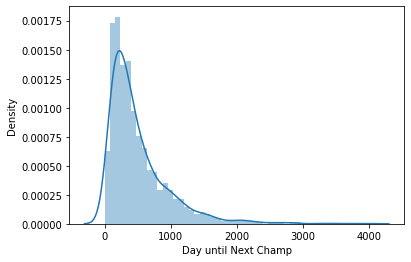

In [33]:
#plot data to see distribution of "Days until Next Champ"
#Visualization 2
#Target selected
import seaborn as sns

y=df['Day until Next Champ']

sns.distplot(y)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


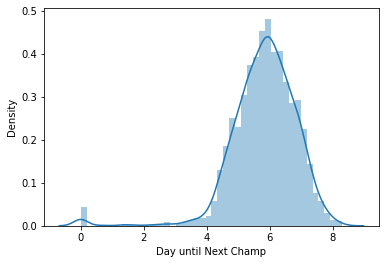

In [11]:
#data has clear left skew so quick log transform to get a diff look on data
#Visualization 3
y_log = np.log1p(y)
sns.distplot(y_log)

In [12]:
#import rest of relevant libraries in case we need any of them
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [14]:
#train test split
features = df['Defenses'],df['Division'],['Days']
target = df['Day until Next Champ']

train, test = train_test_split(df,test_size=0.2)
train.shape,test.shape

((1618, 18), (405, 18))

In [15]:
#arrange y target vectors
target = 'Day until Next Champ'
y_train = train[target]
y_test = test[target]

In [16]:
#establish baseline to compare to model later
print('Mean Baseline (Using 0 features)')
guess = y_train.mean()
print(f'{guess: .2f} Days until Next Champ')

Mean Baseline (Using 0 features)
 508.13 Days until Next Champ


In [17]:
#arrange X feature matrix
features = ['Defenses']
X_train = train[features]
X_test = test[features]
print(f'Linear Regression, dependent on: {features}')

Linear Regression, dependent on: ['Defenses']


In [20]:
#Training dataset mean absolute error
#MAE as evaluation metric
y_pred = [guess] * len(y_train)
mae = mean_absolute_error (y_train, y_pred)
print(f'Train Error (Target): {mae: .2f} days')

Train Error (Target):  332.59 days


In [21]:
#Testing dataset mean absolute error
#MAE as evaluation metric
y_pred = [guess] * len(y_test)
mae = mean_absolute_error(y_test,y_pred)
print(f'Test Error (Target): {mae: .2f} days')

Test Error (Target):  330.39 days


In [22]:
# 1. Import the appropriate estimator class from Scikit-Learn here for ease
#of readability
#Linear regression selected as regression model
from sklearn.linear_model import LinearRegression

In [23]:
# 2. Instantiate this class
model=LinearRegression()

In [24]:
# 3. Arrange X features matrix
features = ['Day until Next Champ']
X_train = train[features]
X_test = test [features]
print (f'Linear Regression, dependent on: {features}')

Linear Regression, dependent on: ['Day until Next Champ']


In [25]:
# 4. Fit the model
model.fit (X_train,y_train)
y_pred = model.predict (X_train)
mae = mean_absolute_error(y_train,y_pred)
print (f'Train Error: {mae: .2f} points')

Train Error:  0.00 points


In [26]:
# 5. Apply the model to new data
#MAE as evaluation metric
y_pred = model.predict (X_test)
mae = mean_absolute_error (y_test,y_pred)
print (f'Test Error: {mae: .2f} days')

Test Error:  0.00 days


In [ ]:
#some error checking please ignore
#print(y_train)

In [29]:
#taking another look at data
import plotly.express as px
px.scatter(df,x='Defenses',y='Day until Next Champ',trendline='ols')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [30]:
#displaying df again as a 'gut check' for human error or accidental changes
#to dataset
dataset = df
df.head()

,Belt,Division,Division Group,No.,Name,Country,Date,Location,Defenses,Days,Ended,Notes,Next Champ Date,Day until Next Champ,Region,Continent,Title Type,Era
0,WBA,Heavyweight,Heavyweight,1,Floyd Patterson,US,1962-08-23,NaN,0,34,NaN,Patterson won the NBA title from Ingemar Johan...,9/25/1962,33.0,North America,North America,NaN,1960s
1,WBA,Heavyweight,Heavyweight,2,Sonny Liston,US,1962-09-25,NaN,1,519,NaN,NaN,2/25/1964,518.0,North America,North America,NaN,1960s
2,WBA,Heavyweight,Heavyweight,3,Muhammad Ali,US,1964-02-25,NaN,0,?,NaN,Ali was stripped for facing Liston in a rematc...,3/5/1965,374.0,North America,North America,NaN,1960s
3,WBA,Heavyweight,Heavyweight,4,Ernie Terrell (v. Eddie Machen),US,1965-03-05,NaN,2,703,NaN,NaN,2/6/1967,703.0,North America,North America,NaN,1960s
4,WBA,Heavyweight,Heavyweight,5,Muhammad Ali (2),US,1967-02-06,NaN,1,446,NaN,Ali was stripped due to his refusal to be draf...,4/27/1968,446.0,North America,North America,NaN,1960s


In [31]:
#Fitting and evaluating RandomForestClassifier
from  sklearn.ensemble import RandomForestClassifier
import category_encoders as ce 
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

#build a pipeline for a ransom forest
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_jobs=-1, random_state=1964)
)

#fit on train, and score on val 
pipeline.fit(X_train, y_train)
print('Validation accuracy is', pipeline.score(X_train, y_train))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Validation accuracy is 1.0
